In [1]:
#%% Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas

In [2]:
## Deterministic solution
def sdd(x, D, m, j):
    return j / np.sqrt(D * m) * np.exp(-x / np.sqrt(D / m))

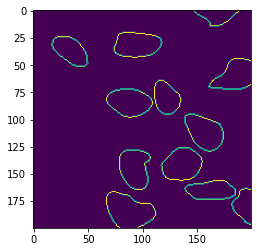

In [3]:
from skimage import io
import matplotlib.pyplot as plt

# read the image stack
img = io.imread('Field_Movement.tif')
image = io.imread('Field_Source.tif')
rec = io.imread('Field_Receptors.tif')

# show the image
plt.imshow(rec)

In [4]:
receptorClass = np.array(rec)
rows, cols = np.where(receptorClass == 255) #convert to 2d array
recepCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows):
    recepCoords = np.append(recepCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1

#ok.

array([19., 36.])

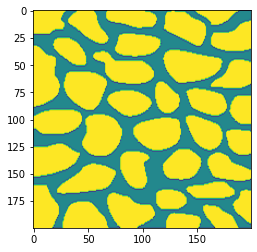

In [5]:
plt.imshow(img)

In [6]:
boundaryClass = np.array(img)

#boundaryClass = np.transpose(boundaryClass)
boundaryClass

#if a particle is at [y][x] then it will have the said boundary conditions
#eg [1][0] will have the boundary condition 8 (cannot move up)


array([[32, 32, 32, ...,  8,  8,  7],
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 16, 16, 15],
       ...,
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 16, 16, 15],
       [32, 32, 32, ..., 12, 12, 11]], dtype=uint8)

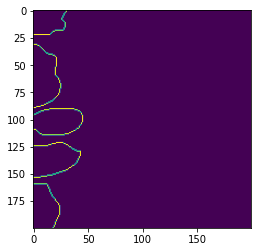

In [7]:
plt.imshow(image)

In [8]:
def pixelClass(ii):
    x, y = int(ii[0]), int(ii[1]) #don't transpose
    return boundaryClass[y][x]  #1 indexed

    #ok.


In [9]:
#x = []
#for i in sourceCoords:
 #   x.append(pixelClass(i))
#x

In [10]:
lookUpTable = pandas.read_csv('lookUpTable.csv')
lookUpTable = lookUpTable.values #removes the headers

#ok.


In [11]:
sourceClass = np.array(image)
rows, cols = np.where(sourceClass == 255) #convert to 2d array
sourceCoords = np.empty((0,2))
i,j = 0,0
while i < len(rows):
    sourceCoords = np.append(sourceCoords, np.array([[cols[i], rows[j]]]), axis = 0)
    i += 1
    j += 1
numSource = len(sourceCoords)


In [12]:
dimImage = image.shape
Lx = dimImage[1] 
Ly = dimImage[0] 


200

array([125.,  95.])

In [14]:
#%% Define Parameters
    
## Simulation parameters
#Lx      = 500                   # length of system (500 um)
dx      = 1.00                  # camera pixel size (1 um)
nx      = round(Lx/dx)          # number of positions (pixels)
xx      = np.arange(nx+1)*dx    # x bin edges

#Ly      = 500                   # length of system (500 um)
dy      = 1.00                  # camera pixel size (1 um)
ny      = round(Ly/dy)          # number of positions (pixels)
yy      = np.arange(ny+1)*dy    # y bin edge

In [15]:
## Dynamic parameters
D               = 10          # diffusion constant
Decay_Time      = 17         # decay time in minutes
mu              = (Decay_Time*60) ** (-1)  # disassociation rate
J               = 0.0015            # Insertion rate

## Probabilities and derived parameters
dt      = dx**2/(D*2*2)         # assumes dy = dx
p_J     = J * dt  #number of source position
p_mu    = mu * dt
k_on = 0.01
k_off = 0.012
## Time Variables

Ttotal  = 5*60*60               # time in seconds
nt      = round(Ttotal/dt)+1
dtsave  = 10*60              # save every "10 mins"
dsave   = round(dtsave/dt)      
nsave   = round(Ttotal/dtsave)+1

In [16]:
k_on*dt*(recepCoords.shape[0])

0.257

In [17]:
k_off*dt*(recepCoords.shape[0])

0.3084

In [18]:
start = time.time()
distribFree = np.empty((0,2))
distribBound = np.empty((0,2))
density = np.zeros((nx,nsave))
birthRate = J*numSource*dt
p_bind = k_on*dt*(recepCoords.shape[0])
p_unbind = k_off*dt*(recepCoords.shape[0])
moveDict = {'l':[-1,0],'r':[1,0], 'u':[0,-1],'d':[0,1]}
count = 0
prev,current = 0,0
for count in range (1,nt):
    ##image source code##
    instBirth = np.random.poisson(birthRate) #random select number born at current time, replaces add
    for ii in range(1, instBirth +1):
        instSource = np.random.choice(numSource) #random select source position, replaces new
        new = [sourceCoords[instSource]]
        distribFree = np.append(distribFree, np.array(new), axis=0)#change shape of sourcePos[instSource]
    pixelClasses = np.empty(0, dtype=int)
    ##obstacle code##
    x = []
    for ii in distribFree: 
        x.append(pixelClass(ii)) #we have some 32's but will throw them away    
    for jj in range(1,17):
        x = np.array(x)
        indexPart = np.where(x == jj)[0] #returns the index in distrib where the particles have said class
        numInClass = len(indexPart)
        numFree = lookUpTable[jj-1][-1] #adjusts the index to the correct one
        randMove = np.random.uniform(low = 1, high = numFree+1, size = numInClass) # shape = len(idxP[0]),
        randMove = randMove.astype(int)
        blank = []
        if numFree> 0:
            moveDir = lookUpTable[jj-1][randMove] #returns a string (lrud), same shape as randMove
            for i in moveDir:
                blank.append(moveDict[i]) #shape = len(idxP[0]), 2
        blank = np.array(blank).reshape(-1,2).astype(int)
        distribFree[indexPart] = distribFree[indexPart] + blank
    numPartFree = len(distribFree) 
    ##binding/unbinding code##
    partBound = np.empty((0,2), dtype= int)
    numBind = np.random.poisson(p_bind)
    numUnbind = np.random.poisson(p_unbind)
    if numPartFree > 0:
        idxDict = {}
        pbCount = 0
        for i in range(distribFree.shape[0]): 
            if (distribFree[i]== recepCoords).all(axis = 1).any(): #if the whole element matches
                partBound = np.append(partBound, np.array([distribFree[i]]), axis = 0)
                idxDict[pbCount] = i
                pbCount += 1
        if numBind < partBound.shape[0]:
            idxDel = []
            idxBind = np.random.choice(partBound.shape[0], numBind, replace = False)
            toBind = partBound[idxBind]
            for i in idxBind:
                k = idxDict[i]
                idxDel.append(k)
            distribFree = np.delete(distribFree, idxDel, axis = 0)
            distribBound = np.append(distribBound, toBind, axis = 0)
    if numUnbind < distribBound.shape[0]:
        idxUnbind = np.random.choice(distribBound.shape[0], numUnbind, replace = False)
        toUnbind = distribBound[idxUnbind]
        distribBound = np.delete(distribBound, idxUnbind, axis = 0)
        distribFree = np.append(distribFree, toUnbind, axis =0)
        #distribFree = np.array(distribFree).reshape(-1,2)
    ##kill code##
    numPartFree = len(distribFree)
    if numPartFree > 0:
        meanDecay = p_mu* numPartFree
        dead = np.random.poisson(meanDecay)
        kill = np.random.choice(numPartFree, dead, replace=False)
        distribFree = np.delete(distribFree,kill,0)
    if count%dsave == 0:
        ind = round(count/dsave) #change later
        print(f'At time step {count} out of {nt-1} with {len(distribFree) + len(distribBound)}  particles')
        print(f'There are {len(distribBound)} bound and {len(distribFree)} free, with {len(partBound)} at receptors')
        #print(f'The {len(partBound)},{numBind} and {numUnbind} ')
        prev = current
        current = len(distribFree) + len(distribBound)
        print(f'The previous is {prev} and current is {current}')
        #np.savetxt(str(ind)+'distribFree.csv', distribFree, fmt='%i', delimiter=",") #keep the data
        #np.savetxt(str(ind)+ 'distribBound.csv', distribBound, fmt ='%i', delimiter = ",") #keep the data
        img1 = np.zeros((Ly+1,Lx+1))
        img2 = np.zeros((Ly+1, Lx+1))
        for coord in distribFree:
            img1[int(coord[1]) , int(coord[0])] +=1
        for coord in distribBound:
            img2[int(coord[1]) , int(coord[0])] +=1
        im1 = Image.fromarray(img1)
        im2 = Image.fromarray(img2)
        im1.save(str(ind)+'free.tif')
        im2.save(str(ind)+'bound.tif')
        if prev!= 0 and np.abs(current/prev-1) < 0.05:
            print('chopped')
elapsed = time.time() - start  

At time step 24000 out of 720000 with 254  particles
There are 6 bound and 248 free, with 4 at receptors
The previous is 0 and current is 254
At time step 48000 out of 720000 with 381  particles
There are 12 bound and 369 free, with 13 at receptors
The previous is 254 and current is 381
At time step 72000 out of 720000 with 463  particles
There are 2 bound and 461 free, with 18 at receptors
The previous is 381 and current is 463
At time step 96000 out of 720000 with 516  particles
There are 6 bound and 510 free, with 15 at receptors
The previous is 463 and current is 516
At time step 120000 out of 720000 with 546  particles
There are 2 bound and 544 free, with 27 at receptors
The previous is 516 and current is 546
At time step 144000 out of 720000 with 531  particles
There are 8 bound and 523 free, with 23 at receptors
The previous is 546 and current is 531
chopped
At time step 168000 out of 720000 with 586  particles
There are 3 bound and 583 free, with 16 at receptors
The previous is

KeyboardInterrupt: 

#### Test Codes
-----------------------------

In [ ]:
img = np.zeros((Ly+1,Lx+1))
#for coord in distribFree:
 #   img[int(coord[1]) , int(coord[0])] +=1
for coord in distribBound:
    img[int(coord[1]) , int(coord[0])] +=1
im = Image.fromarray(img)

#colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is red
#cm = LinearSegmentedColormap.from_list(
    #    "Custom", colors, N=50)
#plt.imshow(img, cmap=cm)
plt.imshow(img, interpolation='nearest')
#plt.show()
plt.show()
#im.save('run2.tif')